# cadCAD Tutorials: The Robot and the Marbles, part 7
In parts [1](../robot-marbles-part-1/robot-marbles-part-1.ipynb) and [2](../robot-marbles-part-2/robot-marbles-part-2.ipynb) we introduced the 'language' in which a system must be described in order for it to be interpretable by cadCAD and some of the basic concepts of the library:
* State Variables
* Timestep
* State Update Functions
* Partial State Update Blocks
* Simulation Configuration Parameters
* Policies

In [part 3](../robot-marbles-part-3/robot-marbles-part-3.ipynb) we covered how to describe the presence of asynchronous subsystems within the system being modeled in cadCAD. And [part 4](../robot-marbles-part-4/robot-marbles-part-4.ipynb) introduced Monte Carlo simulations.

In [part 6](../robot-marbles-part-4/robot-marbles-part-6.ipynb) we conducted A/B tests using different system initial conditions to see the differences.

In this notebook, we'll cover cadCAD's support for parameters and parameter sweeping, a useful feature to produce multiple configurations with different parameters. As in Part 6, let's start by copying the base configuration with which we ended Part 4. Here's the description of that system:

__The robot and the marbles__  
* Picture a box (`box_A`) with ten marbles in it; an empty box (`box_B`) next to the first one; and __two__ robot arms capable of taking a marble from any one of the boxes and dropping it into the other one. 
* The robots are programmed to take one marble at a time from the box containing the largest number of marbles and drop it in the other box. They repeat that process until the boxes contain an equal number of marbles.
* The robots act __asynchronously__ and __non-deterministically__; at every timestep each robot acts with a probability P: 50% for robot 1 and 33.33% for robot 2.

In [1]:
%%capture
from numpy.random import rand

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# List of all the state variables in the system and their initial values
initial_conditions = {
    'box_A': 10, # as per the description of the example, box_A starts out with 10 marbles in it
    'box_B': 0 # as per the description of the example, box_B starts out empty
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# In this example, we'll run the simulation once (N=1) and its duration will be of 10 timesteps
# We'll cover the `M` key in a future article. For now, let's leave it empty
simulation_parameters = {
    'T': range(10),
    'N': 50, # We'll run the same simulation 50 times; the random events in each simulation are independent
    'M': {}
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# We specify the robot arm's logic in a Policy Function
def robot_arm(params, step, sL, s):
    add_to_A = 0
    if (s['box_A'] > s['box_B']):
        add_to_A = -1
    elif (s['box_A'] < s['box_B']):
        add_to_A = 1
    return({'add_to_A': add_to_A, 'add_to_B': -add_to_A})
    
robots_probabilities = [0.5,1/3] # Robot 1 acts with a 50% probability; Robot 2, 33.33%

def robot_arm_1(params, step, sL, s):
    _robotId = 1
    if rand()<robots_probabilities[_robotId-1]: # draw a random number between 0 and 1; if it's smaller than the robot's parameter, it acts
        return robot_arm(params, step, sL, s)
    else:
        return({'add_to_A': 0, 'add_to_B': 0}) # otherwise, the robot doesn't interfere with the system

def robot_arm_2(params, step, sL, s):
    _robotId = 2
    if rand()<robots_probabilities[_robotId-1]: # draw a random number between 0 and 1; if it's smaller than the robot's parameter, it acts
        return robot_arm(params, step, sL, s)
    else:
        return({'add_to_A': 0, 'add_to_B': 0}) # otherwise, the robot doesn't interfere with the system



    
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# We make the state update functions less "intelligent",
# ie. they simply add the number of marbles specified in _input 
# (which, per the policy function definition, may be negative)
def increment_A(params, step, sL, s, _input):
    y = 'box_A'
    x = s['box_A'] + _input['add_to_A']
    return (y, x)

def increment_B(params, step, sL, s, _input):
    y = 'box_B'
    x = s['box_B'] + _input['add_to_B']
    return (y, x)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, 
# the user specifies if state update functions will be run in series or in parallel
# and the policy functions that will be evaluated in that block
partial_state_update_blocks = [
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'robot_arm_1': robot_arm_1,
            'robot_arm_2': robot_arm_2
        },
        'variables': { # The following state variables will be updated simultaneously
            'box_A': increment_A,
            'box_B': increment_B
        }
    }
]
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

In [2]:
%%capture
from cadCAD.configuration import Configuration
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

%matplotlib inline
import pandas as pd
df = pd.DataFrame(raw_result)

In [3]:
from IPython.display import display
tmp_rows = pd.options.display.max_rows
pd.options.display.max_rows = 10
display(df.set_index(['run', 'timestep', 'substep']))
pd.options.display.max_rows = tmp_rows

box_A  box_B
run timestep substep              
1   0        0           10      0
    1        1            9      1
    2        1            9      1
    3        1            7      3
    4        1            7      3
...                     ...    ...
50  6        1            5      5
    7        1            5      5
    8        1            5      5
    9        1            5      5
    10       1            5      5

[550 rows x 2 columns]

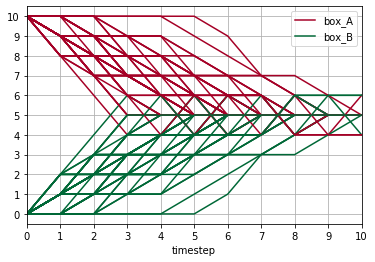

In [4]:
def print_plot(N):
    ax = None
    for i in range(N):
        ax = df[df['run']==i+1].plot('timestep', ['box_A', 'box_B'],
                                         grid=True,
                                         xticks=list(df['timestep'].drop_duplicates()), 
                                         yticks=list(range(1+max(df['box_A'].max(),df['box_B'].max()))),
                                         legend = (ax == None),
                                         colormap = 'RdYlGn',
                                         ax = ax
                                      )
print_plot(simulation_parameters['N'])

## Parameters
The first parameter in policy and state functions is called `params` and it makes reference to the dictionary of parameters of the system. Let's rewrite our `robot_arm` policy to accept a `capacity` parameter that represents the number of marbles an arm can move from one box to another every time. 

In [5]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# We specify the robot arm's logic in a Policy Function
def robot_arm(params, step, sL, s):
    add_to_A = 0
    capacity = params[0]['capacity']
    if (s['box_A'] > s['box_B']):
        add_to_A = -capacity
    elif (s['box_A'] < s['box_B']):
        add_to_A = capacity
    return({'add_to_A': add_to_A, 'add_to_B': -add_to_A})
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

You may remember in previous tutorials we left the `M` key as an empty object and promised to use the parameters dictionary in further articles. This is the time.

We set arm's `capacity` to 2.

In [6]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# In this example, we'll run the simulation once (N=50) and its duration will be of 10 timesteps
# `M` is a dictionary of parameters key in a future article. For now, let's leave it empty

simulation_parameters = {
    'T': range(10),
    'N': 50, # We'll run the same simulation 50 times; the random events in each simulation are independent
    'M': {
        'capacity': 2
    }
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

An we see the effect it has over the system.

In [7]:
%%capture
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

%matplotlib inline
import pandas as pd
df = pd.DataFrame(raw_result)

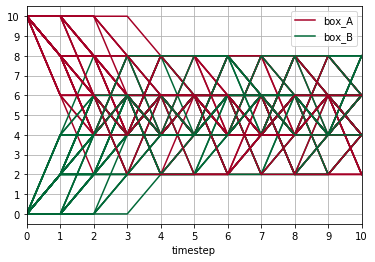

In [8]:
print_plot(simulation_parameters['N'])

## Parameter sweeping
In order to simulate two different versions of the same system, we create two `Configuration` objects to pass to the `Executor` instead of just one. For example, suppose we wanted to test the system under two different arm capacities.

In [9]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# We specify the robot arm's logic in a Policy Function
def robot_arm(params, step, sL, s):
    add_to_A = 0
    capacity = params['capacity']
    if (s['box_A'] > s['box_B']):
        add_to_A = -capacity
    elif (s['box_A'] < s['box_B']):
        add_to_A = capacity
    return({'add_to_A': add_to_A, 'add_to_B': -add_to_A})
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

In [10]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# We use `config_sim` to generate a list of configurations
from cadCAD.configuration.utils import config_sim
simulation_parameters = config_sim(
    {
        'T': range(10),
        'N': 50, # We'll run the same simulation 50 times; the random events in each simulation are independent
        'M': {
            'capacity': [1, 2]
        }
    }
)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

simulation_parameters

[{'N': 50, 'T': range(0, 10), 'M': {'capacity': 1}},
 {'N': 50, 'T': range(0, 10), 'M': {'capacity': 2}}]

Just like we did before, we package those initial conditions along with the partial state update blocks and the simulation parameters into `Configuration` objects. This time using the `append_configs` util for convenience. The configurations are stored in the `configs` list.

In [11]:
from cadCAD.configuration import append_configs
from cadCAD import configs
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# The configurations above are then packaged into a `Configuration` object
append_configs(
    initial_state=initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters #dict containing simulation parameters
)

[{'N': 50, 'T': range(0, 10), 'M': {'capacity': 1}}, {'N': 50, 'T': range(0, 10), 'M': {'capacity': 2}}]
[{'N': 50, 'T': range(0, 10), 'M': {'capacity': 1}}, {'N': 50, 'T': range(0, 10), 'M': {'capacity': 2}}]


And now we can execute the simulation of those two different versions of the system in parallel. In order to accomplish that, we use an `ExecutionContext` of mode `multi_proc`

In [12]:
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.multi_proc)
executor = Executor(exec_context, configs) # Pass an array configuration objects

And we are ready to execute the simulation. The `execute()` method will return a list of tuples - the first element of those tuples correspond to the datapoints of each one of the versions of the system being simulated.

In [13]:
%%capture
results = []
for raw_result, tensor in executor.execute():
    df = pd.DataFrame(raw_result)
    results.append(df)

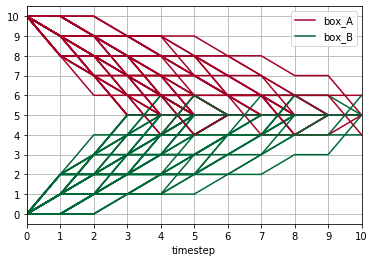

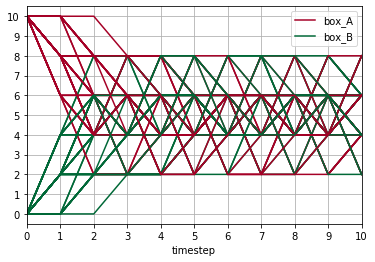

In [14]:
for df in results:
    print_plot(simulation_parameters[0]['N'])

As stated, parameters can be used to parametrize the states and policies, and we can run parallel simulations testing different parameters generating different configurations with `config_sim`.